Instalamos y actualizamos fastai para luego importar los modulos necesarios

In [2]:
%pip install -Uqq fastai
%pip install -Uqq fastbook

from fastbook import *
from fastai import *
from fastai.vision.widgets import *
import os

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Definimos la API key para la busqueda de imagens por bing

In [2]:
# key = os.environ.get('AZURE_SEARCH_KEY', '')
# Generar una clave en https://azure.microsoft.com/es-es/services/cognitive-services/bing-web-search-api/
key = os.environ.get('AZURE_SEARCH_KEY', '')

Buscamos imagenes usando la API Key

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [4]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

Descargamos una imagen de prueba para revisar que sea correcta

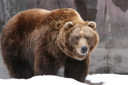

In [5]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128, 128)

Descargamos las imagenes que nos devolvio la búsqueda

In [6]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [7]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls = results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#437) [Path('bears/black/0b7ccf4d-4cb6-4f57-a960-010f23c3eb70.jpg'),Path('bears/black/e79bb856-891b-416b-9812-0a4ebfb92aae.jpg'),Path('bears/black/7e581dc7-c1bc-43a9-9617-cb609038b618.jpg'),Path('bears/black/c4b276d1-f6d0-4da3-8ebb-fae5b58090aa.jpg'),Path('bears/black/c675a633-240f-4fe9-bb54-3556699bc11f.jpg'),Path('bears/black/6554d759-699f-4cd9-9028-e53f5413d870.jpg'),Path('bears/black/e9e3e623-9077-4a4d-85e3-fa3431ef403b.jpg'),Path('bears/black/988974d0-258d-47ce-9cd9-9bf8666c30d7.jpg'),Path('bears/black/f75ba189-10eb-407f-8d47-d2af8403678c.jpg'),Path('bears/black/d19cc024-db5c-41fd-afb5-407f6fe91a8f.jpg')...]

Verificar archivos descargados

In [9]:
failed = verify_images(fns)
failed

(#12) [Path('bears/black/7135ca6e-ca6b-47b0-a120-4d388b0413da.jpg'),Path('bears/black/5655008d-3f89-462e-af2a-76fad36e37b7.jpg'),Path('bears/black/0fd8049f-caad-4fb5-809d-b04ec8f21950.jpg'),Path('bears/teddy/35cf4d2b-bdcc-46cd-bd1c-7ab9a8ed104d.JPG'),Path('bears/teddy/08e247d3-a82d-4dae-8af7-b60345e02e8d.jpg'),Path('bears/teddy/b5d7a44f-1bec-409c-bc94-b7fc71c6bc61.jpg'),Path('bears/teddy/f13e49d3-d03e-4a75-9b8e-290b7d2d899b.jpg'),Path('bears/teddy/05330bf4-878e-4225-87f1-e7cc483eac1c.png'),Path('bears/teddy/31f1796d-4b9c-48c9-9338-31d12f519d6c.jpg'),Path('bears/grizzly/0a4b172d-8a0a-4f7f-b772-da661cee312d.jpg')...]

In [10]:
failed.map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None...]

Creamos un DataLoader

In [11]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter( valid_pct = 0.2, seed = 42 ),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [12]:
dls = bears.dataloaders(path)

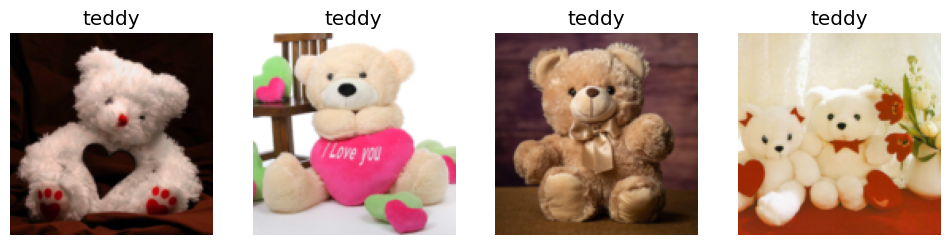

In [13]:
dls.valid.show_batch(max_n = 4, nrows = 1)

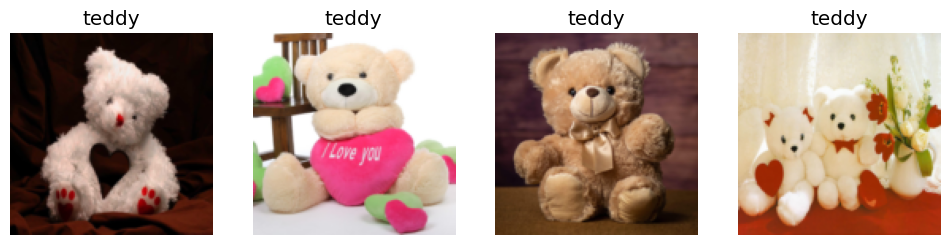

In [14]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

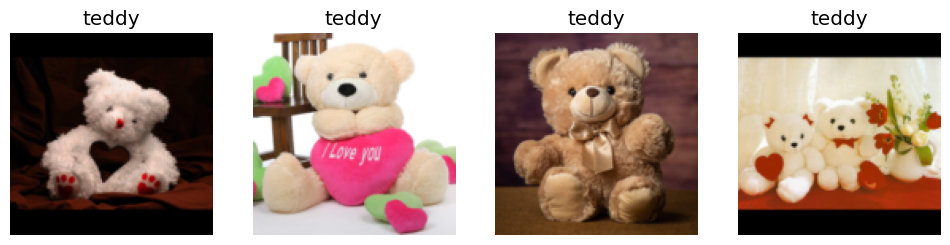

In [15]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

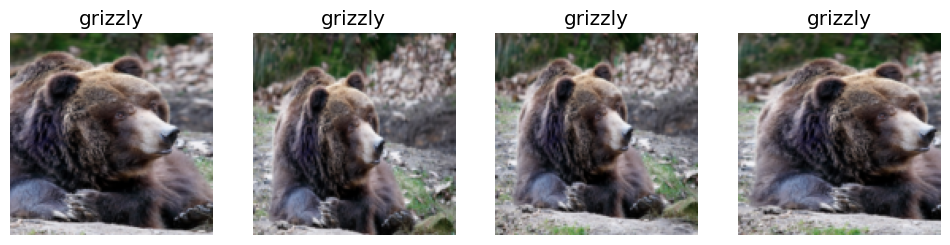

In [16]:
bears = bears.new( item_tfms = RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.train.show_batch( max_n = 4, nrows = 1, unique = True)

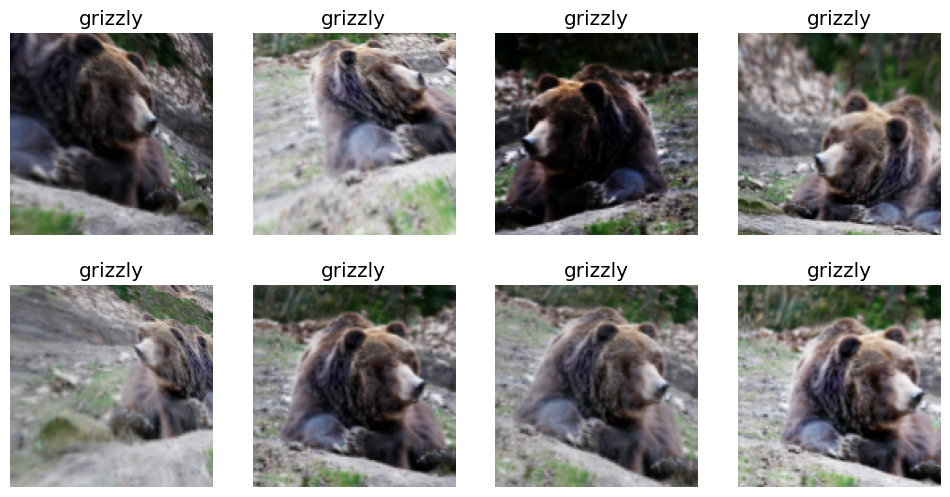

In [19]:
bears = bears.new(item_tfms = Resize(128), batch_tfms = aug_transforms ( mult = 2 ) )
dls = bears.dataloaders(path)
dls.train.show_batch( max_n = 8, nrows = 2, unique = True)

Entrenamiento del modelo y limpieza de los datos

In [21]:
bears = bears.new(
    item_tfms = RandomResizedCrop( 224, min_scale = 0.5 ),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

Creación de "learner" y fine tuning del modelo

In [22]:
learn = vision_learner( dls, resnet18, metrics = error_rate )
learn.fine_tune(6)

/home/xamanek/.virtualenvs/Bears/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xamanek/.virtualenvs/Bears/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/xamanek/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 6.78MB/s]


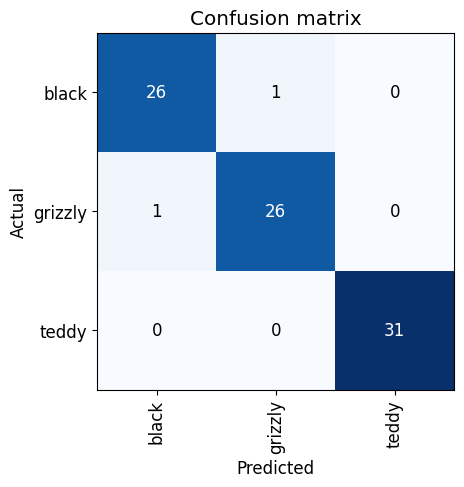

In [23]:
interp = ClassificationInterpretation.from_learner( learn )
interp.plot_confusion_matrix()

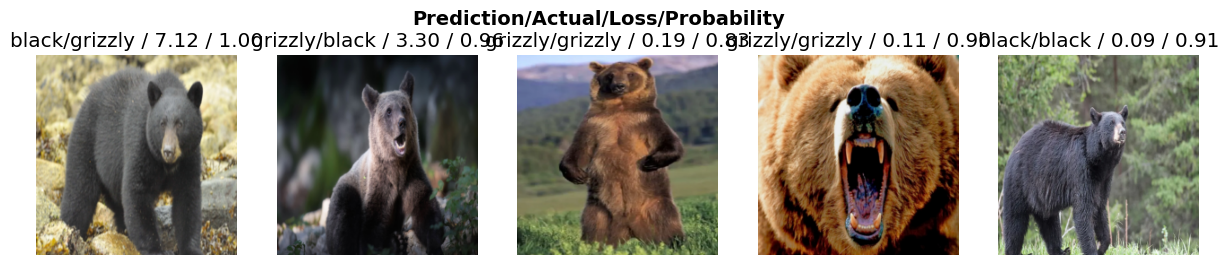

In [24]:
interp.plot_top_losses( 5, nrows = 1 )

Limpiaremos los resultados usando herramientas de FastAI

In [26]:
cleaner = ImageClassifierCleaner( learn )
cleaner

Borraremos y moveremos los elementos que hemos reclasificado a mano con las siguientes lineas

In [27]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move( str( cleaner.fns[idx]), path/cat)

Ahora exportaremos el modelo para producción

In [28]:
learn.export()

Verificamos que el archivo exista usando el método "ls"

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Ahora cargaremos el modelo ya entrenado y exportado para usarlo en una clasificación

In [30]:
learn_inf = load_learner( path/'export.pkl')

In [31]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([4.1360e-08, 1.0000e+00, 1.2507e-07]))

In [32]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [35]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
img = PILImage.create(btn_upload.data[-1])

IndexError: list index out of range

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.8850')

In [ ]:
btn_run = widgets.Button(description = 'Classify' )
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear'),
      btn_upload, btn_run, out_pl, lbl_pred])